In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import os
import tensorflow as tf
import keras
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
import cv2

In [27]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix
import imutils
from mtcnn.mtcnn import MTCNN

In [18]:
train_dir = "archive/train/"
test_dir = "archive/test/"

def Classes_Count(path, name):
    Classes_Dict = {}
    
    for Class in os.listdir(path):
        
        Full_Path = path + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))
        
    df = pd.DataFrame(Classes_Dict, index=[name])
    
    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

In [19]:
pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


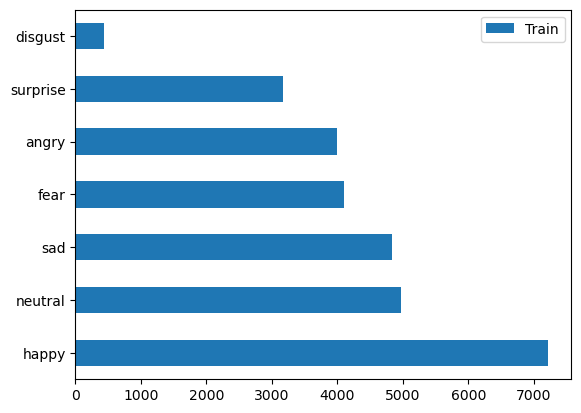

In [20]:
Train_Count.plot(kind='barh');

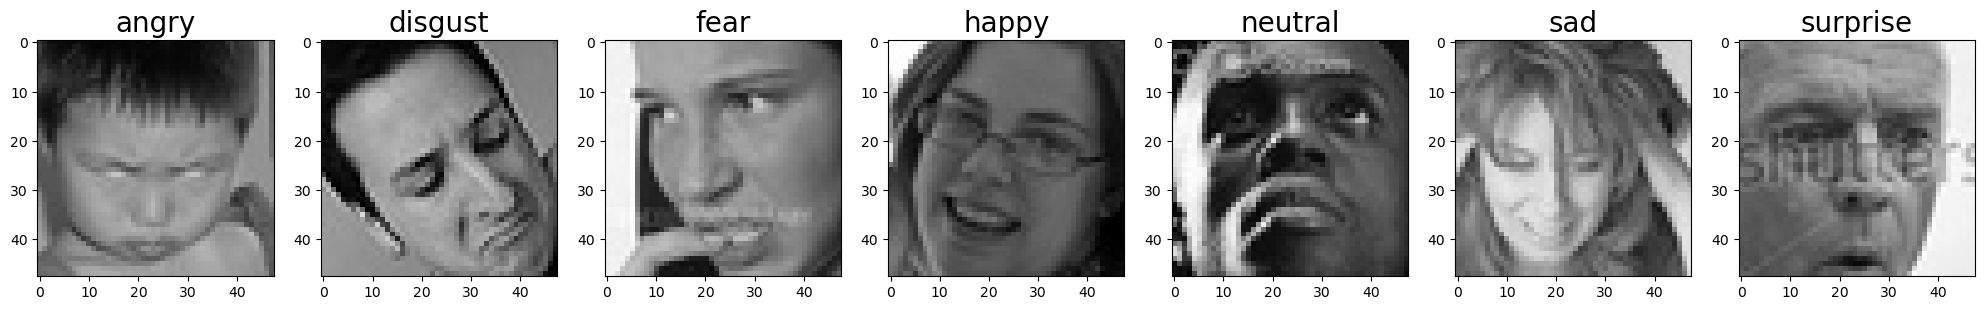

In [21]:
plt.style.use('default')
plt.figure(figsize = (25, 8))
image_count = 1
BASE_URL = train_dir

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize = 20)

In [22]:
img_shape = 48
batch_size = 64
train_data_path = train_dir 
test_data_path = test_dir

In [23]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)


test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [24]:
checkpoint_path = "CNN_Model_Checkpoint"
Checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True, verbose=1)

Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [25]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

In [26]:
Emotion_Classes = ['Angry', 
                  'Disgust', 
                  'Fear', 
                  'Happy', 
                  'Neutral', 
                  'Sad', 
                  'Surprise']
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 7178 images belonging to 7 classes.


In [13]:
model2 = keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_shape, img_shape, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'),
    keras.layers.Dropout(0.25),
    
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'),
    keras.layers.Dropout(0.25),
    
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'),
    keras.layers.Dropout(0.25),
    
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),   
    
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    
    keras.layers.Dense(32, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    
    keras.layers.Dense(7, activation='softmax'),
])

In [14]:
model2.summary()
model2.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                        

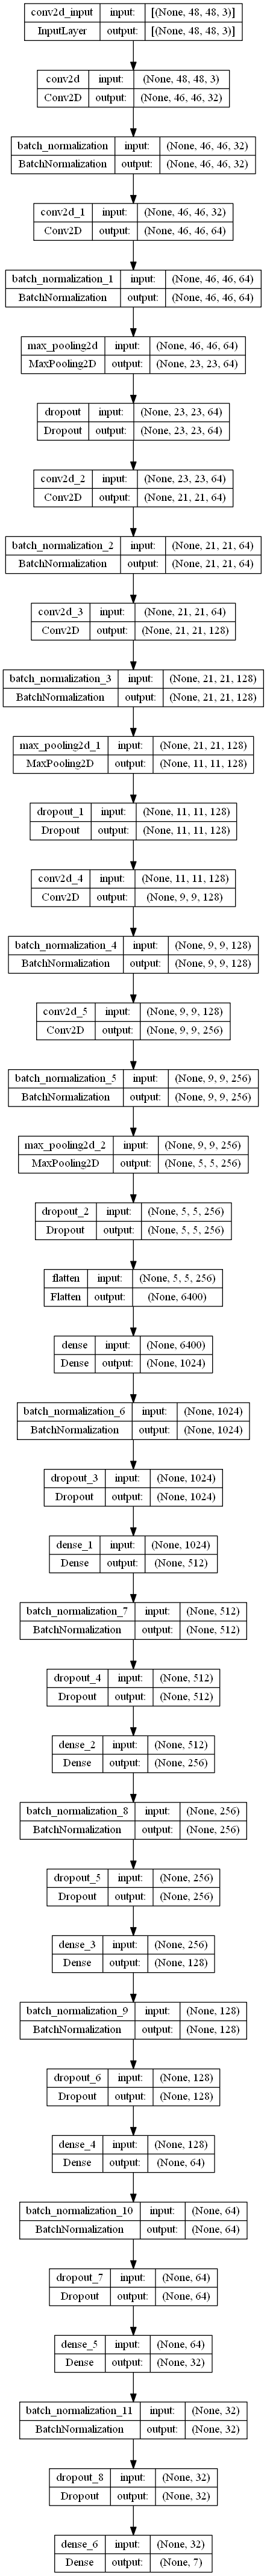

In [15]:
plot_model(model2, to_file='model2.png', show_shapes=True, show_layer_names=True)

In [16]:
CNN_history2 = model2.fit( train_data , validation_data= test_data , epochs=50, batch_size= batch_size,
                            callbacks=callbacks, steps_per_epoch= steps_per_epoch, validation_steps=validation_steps)

Epoch 1/50
448/448 [==============================] - 147s 311ms/step - loss: 2.0468 - accuracy: 0.2109 - val_loss: 1.8226 - val_accuracy: 0.2476 - lr: 0.0010
Epoch 2/50
448/448 [==============================] - 37s 83ms/step - loss: 1.7901 - accuracy: 0.2756 - val_loss: 1.8223 - val_accuracy: 0.2662 - lr: 0.0010
Epoch 3/50
448/448 [==============================] - 37s 84ms/step - loss: 1.6631 - accuracy: 0.3344 - val_loss: 1.6591 - val_accuracy: 0.3654 - lr: 0.0010
Epoch 4/50
448/448 [==============================] - 39s 86ms/step - loss: 1.5308 - accuracy: 0.4055 - val_loss: 1.4937 - val_accuracy: 0.4390 - lr: 0.0010
Epoch 5/50
448/448 [==============================] - 38s 84ms/step - loss: 1.4327 - accuracy: 0.4495 - val_loss: 1.3359 - val_accuracy: 0.4845 - lr: 0.0010
Epoch 6/50
448/448 [==============================] - 38s 85ms/step - loss: 1.3653 - accuracy: 0.4752 - val_loss: 1.2429 - val_accuracy: 0.5257 - lr: 0.0010
Epoch 7/50
448/448 [==============================] - 37

Epoch 43/50
448/448 [==============================] - ETA: 0s - loss: 1.0034 - accuracy: 0.6330
Epoch 43: ReduceLROnPlateau reducing learning rate to 1.0240001069306004e-10.
448/448 [==============================] - 40s 89ms/step - loss: 1.0034 - accuracy: 0.6330 - val_loss: 0.9620 - val_accuracy: 0.6458 - lr: 5.1200e-10
Epoch 44/50
448/448 [==============================] - 37s 83ms/step - loss: 1.0017 - accuracy: 0.6334 - val_loss: 0.9613 - val_accuracy: 0.6445 - lr: 1.0240e-10
Epoch 45/50
448/448 [==============================] - 39s 87ms/step - loss: 1.0061 - accuracy: 0.6309 - val_loss: 0.9621 - val_accuracy: 0.6443 - lr: 1.0240e-10
Epoch 46/50
448/448 [==============================] - ETA: 0s - loss: 1.0065 - accuracy: 0.6319
Epoch 46: ReduceLROnPlateau reducing learning rate to 2.0480002416167767e-11.
448/448 [==============================] - 39s 87ms/step - loss: 1.0065 - accuracy: 0.6319 - val_loss: 0.9624 - val_accuracy: 0.6440 - lr: 1.0240e-10
Epoch 47/50
448/448 [=====

In [18]:
CNN_Score = model2.evaluate(test_data)

print("    Test Loss: {:.5f}".format(CNN_Score[0]))
print("Test Accuracy: {:.2f}%".format(CNN_Score[1] * 100))

113/113 [==============================] - 3s 28ms/step - loss: 0.9605 - accuracy: 0.6454
    Test Loss: 0.96054
Test Accuracy: 64.54%


In [19]:
CNN_Predictions = model2.predict(test_data)


CNN_Predictions = np.argmax(CNN_Predictions, axis=1)

113/113 [==============================] - 3s 28ms/step


Text(0.5, 1.0, 'CNN Confusion Matrix')

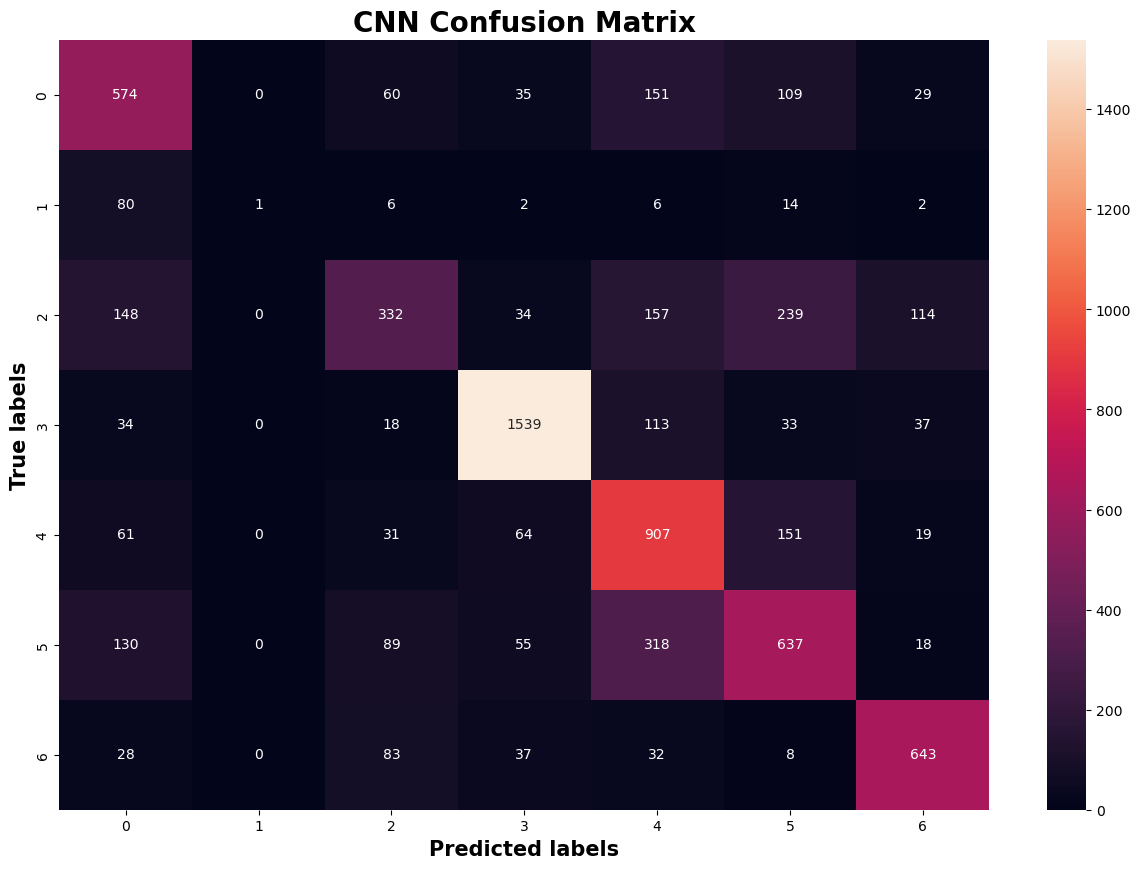

In [20]:
fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, CNN_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('CNN Confusion Matrix', fontsize=20, fontweight='bold')

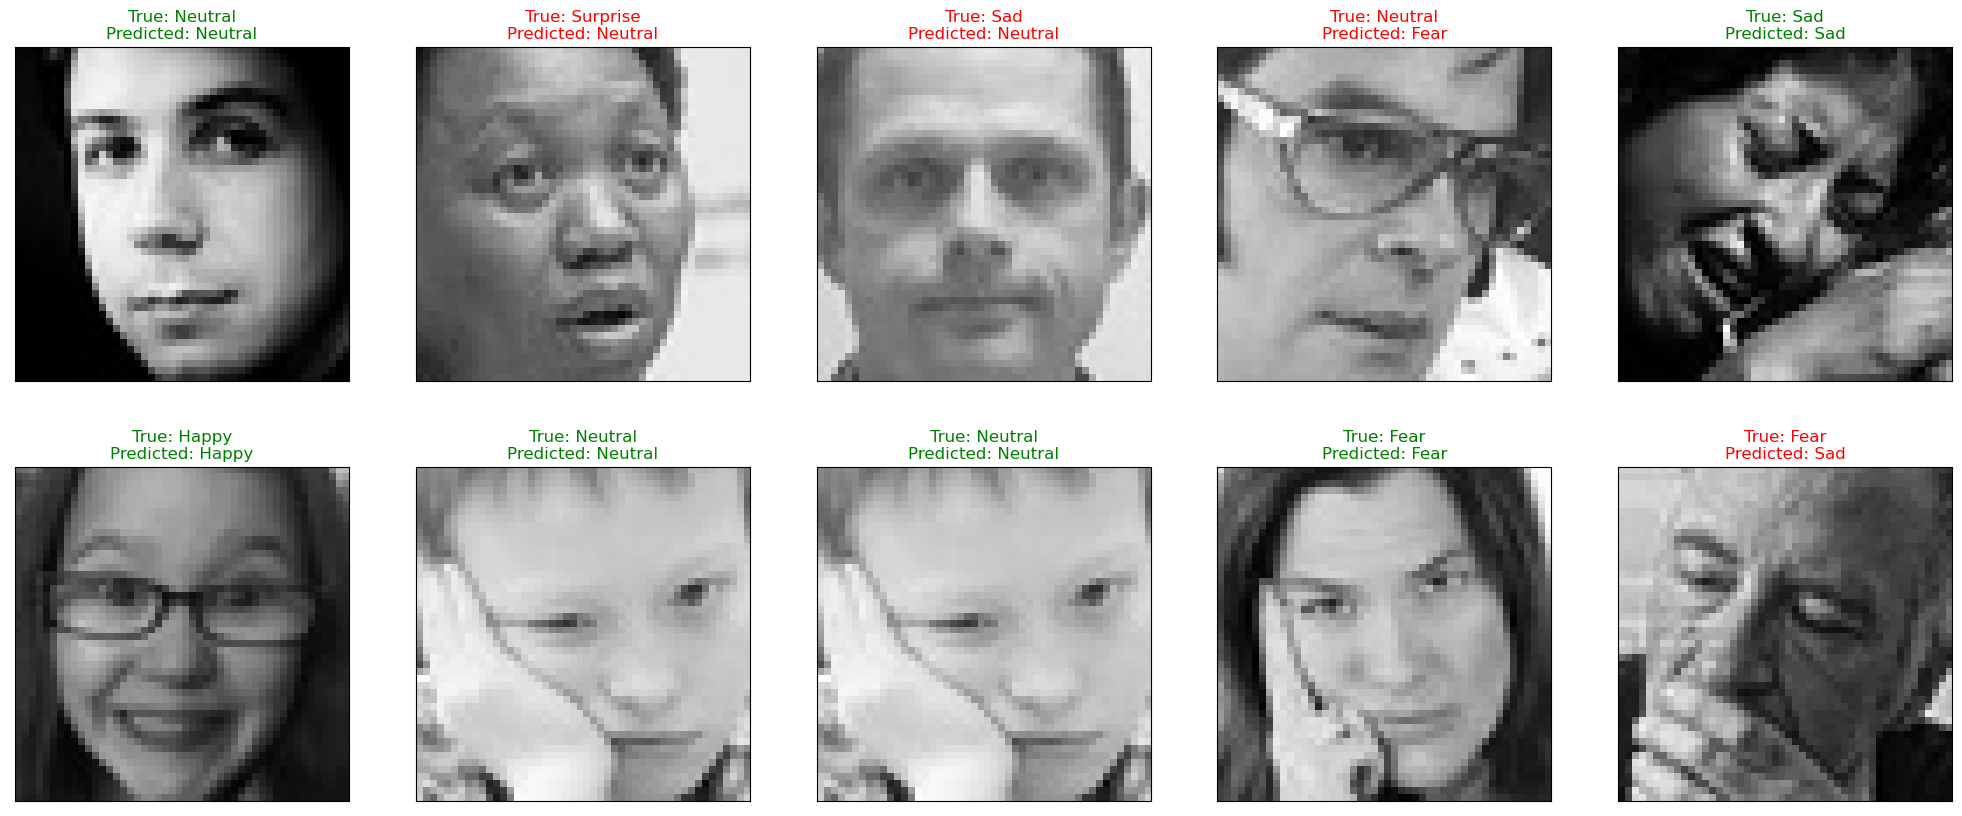

<Figure size 640x480 with 0 Axes>

In [22]:
Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(model2.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

In [128]:
model2.save('my_model')

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


In [13]:
new_model = tf.keras.models.load_model('my_model')

In [2]:
detector = MTCNN()

In [33]:
def detected_face(image_path):
    image = cv2.imread(image_path)

    if image.shape[0] < image.shape[1]:
        image = imutils.resize(image, height=1000)
    else:
        image = imutils.resize(image, width=1000)

    image_size = np.asarray(image.shape)[0:2]

    faces_boxes = detector.detect_faces(image)
    image_detected = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    marked_color = (0, 255, 0, 1)

    if faces_boxes:
        face_n = 0  
        for face_box in faces_boxes:
            face_n += 1
            x, y, w, h = face_box['box']

            d = h - w  
            w = w + d  
            x = np.maximum(x - round(d / 4), 0)
            x1 = np.maximum(x - round(w / 10), 0)
            y1 = np.maximum(y - round(h / 10), 0)
            x2 = np.minimum(x + w + round(w / 10), image_size[1])
            y2 = np.minimum(y + h + round(h / 10), image_size[0])

            print(x1, y1, x2, y2, image_size[0], image_size[1])

            cropped = image_detected[y1:y2, x1:x2, :]

            face_file_name = str(face_box['confidence']) + '.' + str(face_n) + '.jpg'

            if face_box['confidence'] > 0.99:  
                cv2.rectangle(
                    image_detected,
                    (x1, y1),
                    (x2, y2),
                    (255, 102, 0, 1),
                    1
                )
                RGBImg= cv2.resize(cropped,(48,48))
                RGBImg = RGBImg/255.
                pred = new_model.predict(np.expand_dims(RGBImg, axis=0))
                pred_class = Emotion_Classes[pred.argmax()]
                face_image = cv2.resize(cropped, (160, 160), interpolation=cv2.INTER_AREA)
                cv2.putText(image_detected, pred_class, (int(x1),
                                              int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 102, 0), 2, cv2.LINE_AA)

                face_path = 'faces/selected/' + face_file_name

                print('\033[92m' + face_file_name + '\033[0m')

            else:
                cv2.rectangle(
                    image_detected,
                    (x1, y1),
                    (x2, y2),
                    (0, 0, 255, 1),
                    1
                )
                RGBImg= cv2.resize(cropped,(48,48))
                RGBImg = RGBImg/255.
                pred = new_model.predict(np.expand_dims(RGBImg, axis=0))
                pred_class = Emotion_Classes[pred.argmax()]
                face_image = cv2.resize(cropped, (160, 160), interpolation=cv2.INTER_AREA)
                cv2.putText(image_detected, pred_class, (int(x1),
                                              int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                face_path = 'faces/rejected/' + face_file_name

                print('\033[91m' + face_file_name + '\033[0m')

            cv2.imwrite(face_path, face_image)
        cv2.imwrite('people-detected.jpg', image_detected)
        plt.imshow(cv2.cvtColor(image_detected, cv2.COLOR_BGR2RGB))

3/3 [==============================] - 0s 23ms/step
825 516 1020 711 1000 1620
1/1 [==============================] - 0s 24ms/step
0.9999946355819702.1.jpg
236 333 428 525 1000 1620
1/1 [==============================] - 0s 21ms/step
0.9999614953994751.2.jpg
1453 316 1620 486 1000 1620
1/1 [==============================] - 0s 21ms/step
0.9999550580978394.3.jpg
45 232 261 448 1000 1620
1/1 [==============================] - 0s 18ms/step
0.9999228715896606.4.jpg
713 332 903 522 1000 1620
1/1 [==============================] - 0s 18ms/step
0.9998986721038818.5.jpg
19 54 201 236 1000 1620
1/1 [==============================] - 0s 20ms/step
0.9997425675392151.6.jpg
25 431 229 635 1000 1620
1/1 [==============================] - 0s 20ms/step
0.999672532081604.7.jpg
251 502 487 738 1000 1620
1/1 [==============================] - 0s 21ms/step
0.9996492862701416.8.jpg
1191 320 1372 501 1000 1620
1/1 [==============================] - 0s 22ms/step
0.9995786547660828.9.jpg
447 94 635 282 1000 1

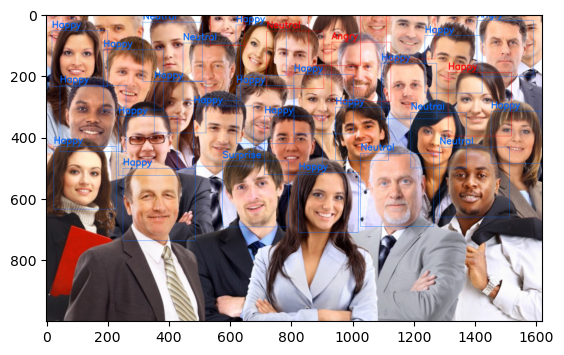

In [34]:
detected_face("people.jpg")